In [50]:
# 1️⃣ Import Libraries
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [51]:
DATASET_PATH = r"C:\Users\arsha\Downloads\archive (2)"
LABELED_FILE = os.path.join(DATASET_PATH, "labeled_anomalies.csv")

labeled_df = pd.read_csv(LABELED_FILE)

# Convert anomaly_sequences string → list
labeled_df["anomaly_sequences"] = labeled_df["anomaly_sequences"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

labeled_df.head()


,chan_id,spacecraft,anomaly_sequences,class,num_values
0,P-1,SMAP,"[[2149, 2349], [4536, 4844], [3539, 3779]]","[contextual, contextual, contextual]",8505
1,S-1,SMAP,"[[5300, 5747]]",[point],7331
2,E-1,SMAP,"[[5000, 5030], [5610, 6086]]","[contextual, contextual]",8516
3,E-2,SMAP,"[[5598, 6995]]",[point],8532
4,E-3,SMAP,"[[5094, 8306]]",[point],8307


In [52]:
CHANNEL_ID = "P-1"   # change channel here


In [53]:
# Load Sensor Data (.npy)
channel_file = os.path.join(
    DATASET_PATH,
    "data", "data", "test",
    f"{CHANNEL_ID}.npy"
)

print("File exists:", os.path.exists(channel_file))

values = np.load(channel_file)
print("Raw shape:", values.shape)


File exists: True
Raw shape: (8505, 25)


In [54]:
# Convert Multivariate → Single Time Series

# We intentionally select one telemetry dimension for stability

values_1d = values[:, 0]

channel_data = pd.DataFrame({
    "value": values_1d
})

channel_data.head()


,value
0,-0.695162
1,-0.685704
2,-0.725719
3,-0.761368
4,-0.745362


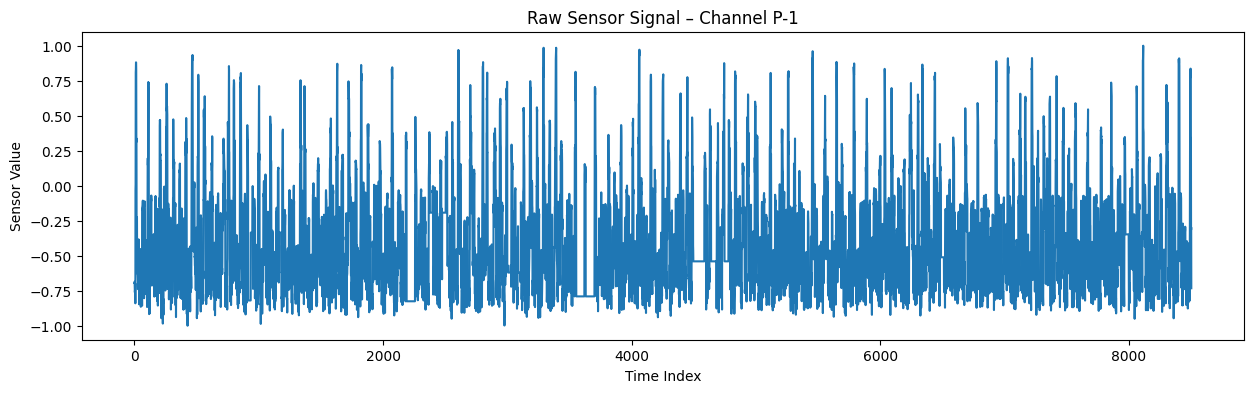

In [55]:

# 📊 Raw Sensor Signal
plt.figure(figsize=(15,4))
plt.plot(channel_data["value"])
plt.title(f"Raw Sensor Signal – Channel {CHANNEL_ID}")
plt.xlabel("Time Index")
plt.ylabel("Sensor Value")
plt.show()


In [56]:
# Feature Engineering
ROLLING_WINDOW = 50

channel_data["rolling_mean"] = channel_data["value"].rolling(ROLLING_WINDOW).mean()
channel_data["rolling_std"]  = channel_data["value"].rolling(ROLLING_WINDOW).std()

channel_data["zscore"] = (
    channel_data["value"] - channel_data["rolling_mean"]
) / channel_data["rolling_std"]

channel_data["lag_1"] = channel_data["value"].shift(1)

channel_data.dropna(inplace=True)

channel_data.head()


,value,rolling_mean,rolling_std,zscore,lag_1
49,-0.644962,-0.397177,0.493890,-0.501700,-0.460895
50,-0.532921,-0.393932,0.492423,-0.282254,-0.644962
51,-0.864678,-0.397512,0.495230,-0.943332,-0.532921
52,-0.756275,-0.398123,0.495662,-0.722573,-0.864678
53,-0.748272,-0.397861,0.495469,-0.707231,-0.756275


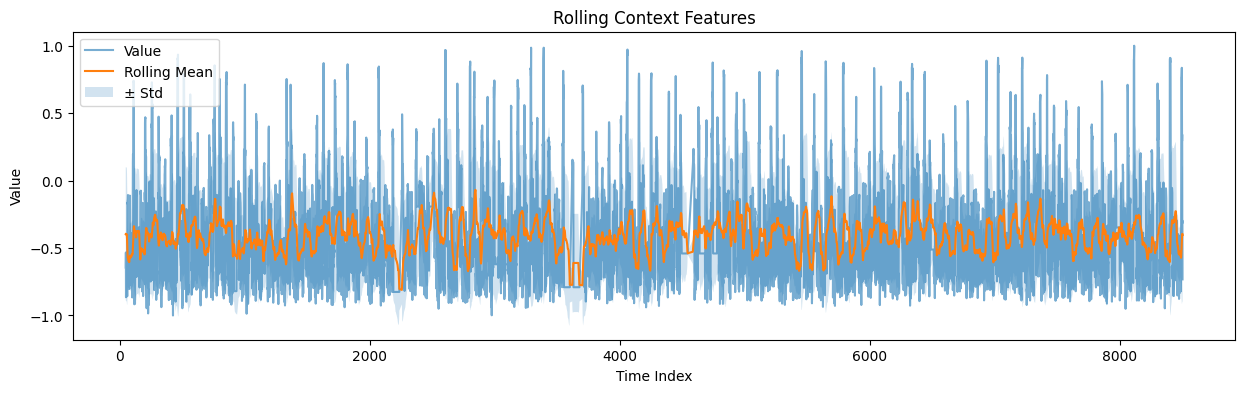

In [57]:

# 📊 Rolling Context Visualization
plt.figure(figsize=(15,4))
plt.plot(channel_data["value"], alpha=0.6, label="Value")
plt.plot(channel_data["rolling_mean"], label="Rolling Mean")

plt.fill_between(
    channel_data.index,
    channel_data["rolling_mean"] - channel_data["rolling_std"],
    channel_data["rolling_mean"] + channel_data["rolling_std"],
    alpha=0.2,
    label="± Std"
)

plt.title("Rolling Context Features")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.show()


In [58]:
# Feature Matrix
FEATURES = ["value", "rolling_mean", "rolling_std", "zscore", "lag_1"]
X = channel_data[FEATURES]


In [59]:
# Hyperparameter Tuning (Isolation Forest)
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("iforest", IsolationForest(random_state=42))
])

param_grid = {
    "iforest__n_estimators": [100, 200],
    "iforest__max_samples": [0.6, 0.8],
    "iforest__contamination": [0.01, 0.02, 0.05],
    "iforest__max_features": [1.0]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X)

print("Best Parameters:", grid.best_params_)


C:\Users\arsha\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'iforest__contamination': 0.01, 'iforest__max_features': 1.0, 'iforest__max_samples': 0.6, 'iforest__n_estimators': 100}


In [60]:
# Train Final Model (Per Channel)
best_model = grid.best_estimator_

channel_data["anomaly_ml"] = best_model.predict(X)
channel_data["anomaly_ml"] = channel_data["anomaly_ml"].map({1: 0, -1: 1})

channel_data["anomaly_ml"].value_counts()


anomaly_ml
0    8273
1      84
Name: count, dtype: int64

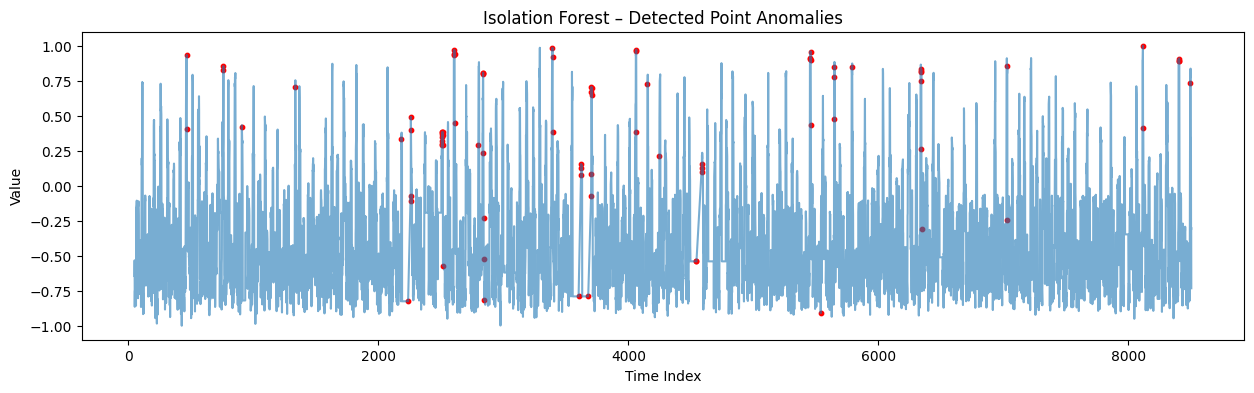

In [61]:
# ML-Detected Point Anomalies
plt.figure(figsize=(15,4))
plt.plot(channel_data["value"], alpha=0.6)

plt.scatter(
    channel_data.index[channel_data["anomaly_ml"] == 1],
    channel_data["value"][channel_data["anomaly_ml"] == 1],
    color="red",
    s=10
)

plt.title("Isolation Forest – Detected Point Anomalies")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.show()


In [62]:
# Detect Recurring Anomalies
RECURRING_WINDOW = 200
RECURRING_THRESHOLD = 10

channel_data["recurring_count"] = (
    channel_data["anomaly_ml"]
    .rolling(RECURRING_WINDOW)
    .sum()
)

channel_data["recurring_flag"] = (
    channel_data["recurring_count"] > RECURRING_THRESHOLD
)


In [63]:
# Extract Recurring Segments
segments = []
start = None

for i in range(len(channel_data)):
    if channel_data["recurring_flag"].iloc[i] and start is None:
        start = i
    elif not channel_data["recurring_flag"].iloc[i] and start is not None:
        segments.append((start, i - 1))
        start = None

if start is not None:
    segments.append((start, len(channel_data) - 1))

segments


[(2449, 2643), (3599, 3733)]

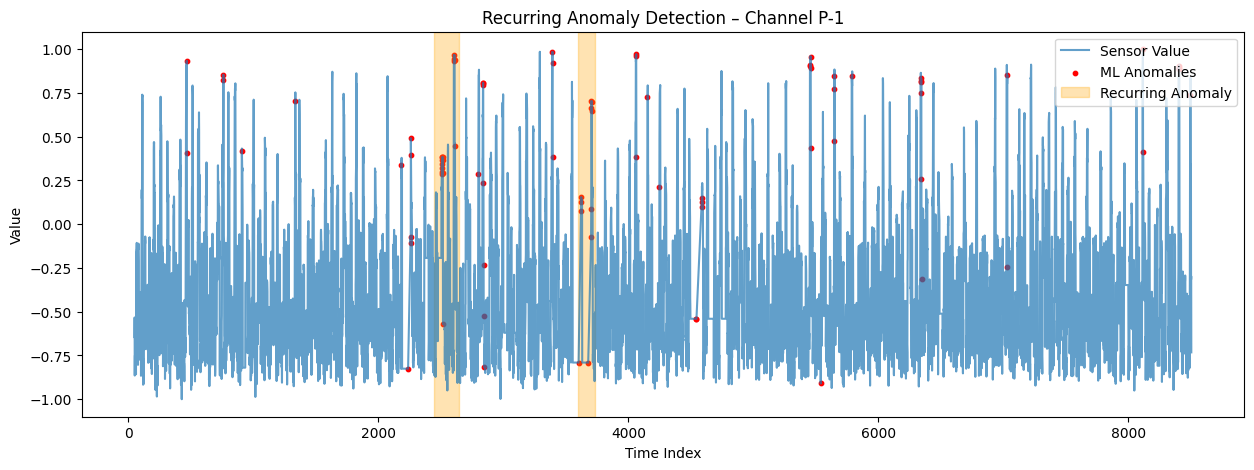

In [64]:
# Recurring Anomaly Visualization
plt.figure(figsize=(15,5))
plt.plot(channel_data["value"], label="Sensor Value", alpha=0.7)

# ML anomalies
mask = channel_data["anomaly_ml"].astype(bool)
plt.scatter(
    channel_data.index[mask],
    channel_data["value"][mask],
    color="red",
    s=10,
    label="ML Anomalies"
)

# Recurring anomaly segments
for i, (start, end) in enumerate(segments):
    if i == 0:
        plt.axvspan(start, end, color="orange", alpha=0.3, label="Recurring Anomaly")
    else:
        plt.axvspan(start, end, color="orange", alpha=0.3)

plt.title(f"Recurring Anomaly Detection – Channel {CHANNEL_ID}")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.show()


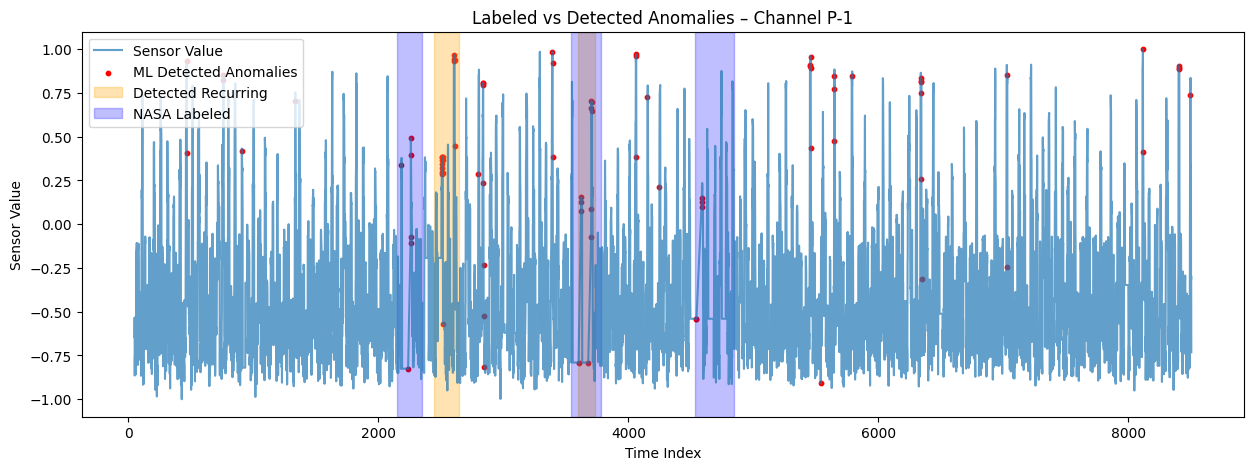

In [65]:
# 🟦 Labeled vs Detected Anomalies (Validation)
channel_info = labeled_df[labeled_df["chan_id"] == CHANNEL_ID].iloc[0]
labeled_sequences = channel_info["anomaly_sequences"]

plt.figure(figsize=(15,5))
plt.plot(channel_data["value"], label="Sensor Value", alpha=0.7)

# ML anomalies
plt.scatter(
    channel_data.index[mask],
    channel_data["value"][mask],
    color="red",
    s=10,
    label="ML Detected Anomalies"
)

# Detected recurring anomalies
for i, (start, end) in enumerate(segments):
    if i == 0:
        plt.axvspan(start, end, color="orange", alpha=0.3, label="Detected Recurring")
    else:
        plt.axvspan(start, end, color="orange", alpha=0.3)

# NASA labeled anomalies
for i, (start, end) in enumerate(labeled_sequences):
    if i == 0:
        plt.axvspan(start, end, color="blue", alpha=0.25, label="NASA Labeled")
    else:
        plt.axvspan(start, end, color="blue", alpha=0.25)

plt.title(f"Labeled vs Detected Anomalies – Channel {CHANNEL_ID}")
plt.xlabel("Time Index")
plt.ylabel("Sensor Value")
plt.legend()
plt.show()
